# import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.integrate import odeint
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Func

In [3]:
def nuke_Epa(x):
    if (abs(x) <= 1):
        return 3/4 * (1-x**2)
    else:
        return 0
    
def nuke_Epa_der(x):
    if (abs(x) <= 1):
        return (-3*x)/2
    else:
        return 0
    
def h_estimate_opt(X_pred, x_train, y_train, par_blur, nuke_der):
    def find_borders(x, some_x, par_blur):
        # x - точки диапазона переменной обучающей выборки
        # some_x - точка, значение в которой нужно предсказать
        # par_blur - параметр размытости
        # border_index -  индекс правой границы
        border_index = len(x)-1
        border_value = some_x + 30*par_blur
        for i in range(len(x)):
            if ( x.iloc[i] > border_value ):
                return i
        return border_index
    
    border_index = find_borders(x_train, X_pred, par_blur)
    x_train = x_train[0:border_index]
    y_train = y_train[0:border_index]
    c = 0
    size = len(x_train)
    T = x_train.iloc[-1] - x_train.iloc[0]
    z = T / (size * (par_blur**2))
    for i in range(size):
        c += y_train.iloc[i] * nuke_der((X_pred-x_train.iloc[i])/par_blur)
    return z * c

In [4]:
def u_one(x):
    if (x>=0):
        return 1
    else: return 0

# Pic

In [5]:
def h_pic(data, data_sample):
    fig = plt.figure(figsize =(10, 5))
    ax = plt.axes()
    plt.title('Восстановление весовой функции')
    ax.plot(data['t'], data['obj1_one'],c='magenta', label='$k$')
    ax.plot(data['t'],data['obj1_one_derivative'],'--', c='magenta', label='$h$')

    ax.plot(data_sample['t'],data_sample['h_estimate'], c='red', label='$\hat{h}$')

    ax.scatter(data_sample['t'], data_sample['obj1_one'],c='#D752FF', s=10)
    ax.scatter(data_sample['t'], data_sample['obj1_one_derivative'],c='#D752FF', s=10)

    plt.legend()
    plt.grid()
    plt.show()

def w_pic(data, data_sample):
    fig = plt.figure(figsize =(10, 5))
    ax = plt.axes()
    plt.title('Обратная весовая функция')
    ax.plot(data['t'], data['obj1_one'],c='magenta', label='$k$')
    ax.plot(data['t'],data['obj1_one_derivative'],'--', c='magenta', label='$h$')

    ax.plot(data_sample['t'],data_sample['h_estimate'], c='red', label='$\hat{h}$')

    ax.scatter(data_sample['t'], data_sample['obj1_one'],c='#D752FF', s=10)
    ax.scatter(data_sample['t'], data_sample['obj1_one_derivative'],c='#D752FF', s=10)

    ax.plot(data_sample['t'],data_sample['w_estimate'], c='blue', label='$\hat{w}$')

    ax.set_xlim(0,2)
    ax.set_ylim(-3000,3000)
    plt.legend()
    plt.grid()
    plt.show()

# work

In [45]:
T = 3
period = 10
dispersion = 0.05
random_state = 10

In [11]:
def normal_DE(y,x, k0, k1, k2, u):
    z = - k0*y[0] - k1*y[1] - k2*y[2]  + u(x)
    return [ y[1], y[2], z ]
def normal_DE(y,x, k0, k1, u):
    z = - k0*y[0] - k1*y[1]  + u(x)
    return [ y[1], z ]

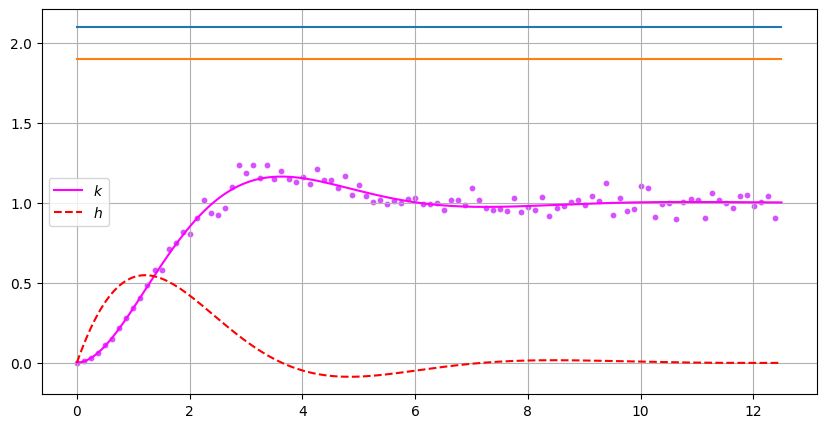

In [12]:
data = pd.DataFrame()
x = np.linspace(0, T, 1000)
data['t'] = x
y0 = [ 0, 0]

k0 , k1 = [ 1, 1 ]
#k0 , k1, k2 = [ 0.9, 2 , 3 ]
sol1 = odeint(normal_DE, y0, x, args=(k0, k1, u_one))

# # k0 , k1, k2 = [ 0.5, 1 , 1.5 ]
# #k0 , k1, k2 = [ 0.9, 2 , 3 ]
# sol1 = odeint(normal_DE, y0, x, args=(k0, k1, k2, u_one))

data['obj1_one'] = sol1[:,0]
data['obj1_one_derivative'] = sol1[:,1]

size = np.shape(data['t'][::period])[0]
data_sample = pd.DataFrame()
# делаем выборку с заданным периодом из всех точек что есть
#добавляем шум к данным
np.random.seed(random_state)
data_sample['t'] = data['t'][::period]
data_sample['obj1_one'] = data['obj1_one'][::period] + dispersion * np.random.normal(0,1,size)*data['obj1_one'][::period] 
data_sample['obj1_one_derivative'] = data['obj1_one_derivative'][::period] + dispersion * np.random.normal(0,1,size)*data['obj1_one_derivative'][::period] 
# data_sample['obj1_one'] = data['obj1_one'][::period] +  np.random.normal(0,dispersion,size)
# data_sample['obj1_one_derivative'] = data['obj1_one_derivative'][::period] + np.random.normal(0,dispersion,size)
# data_sample['obj1_one'] = data['obj1_one'][::period]
# data_sample['obj1_one_derivative'] = data['obj1_one_derivative'][::period]

fig = plt.figure(figsize =(10, 5))
ax = plt.axes()
# plt.title('Восстановление весовой функции')
ax.plot(data['t'], data['obj1_one'],c='magenta', label='$k$')
ax.plot([0,T],[2.1,2.1])
ax.plot([0,T],[1.9,1.9])
ax.plot(data['t'],data['obj1_one_derivative'],'--', c='red', label='$h$')

ax.scatter(data_sample['t'], data_sample['obj1_one'],c='#D752FF', s=10)
# ax.scatter(data_sample['t'], data_sample['obj1_one_derivative'],c='#D752FF', s=10)

plt.legend()
plt.grid()
plt.show()

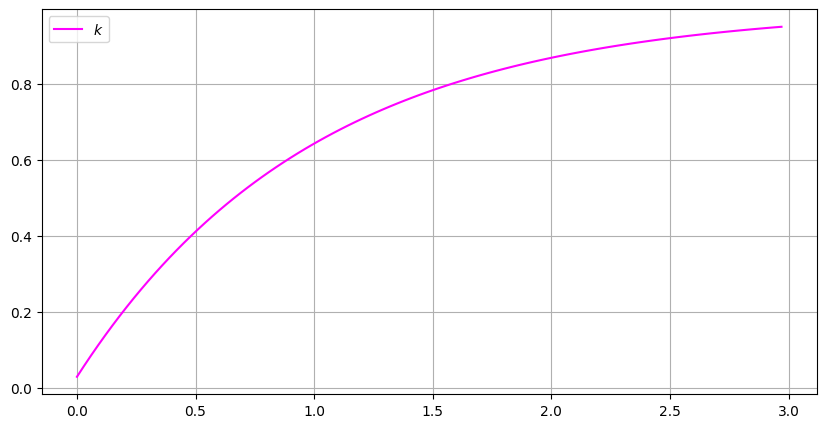

In [72]:
def normal_DE( x, y ):  # правая часть дифура в нормальной форме y'=f(x,y)
    return - y + u_one(x)
    return (y*( x + y )/( x**2 ))
 
# находим решение с шагом h с начальными условиями y(x0)=y0
# x - конец отрезка
def rungeKutta(x0, y0, x, h):
    # Count number of iterations using step size or
    # step height h
    n = (int)((x - x0)/h) 
    # Iterate for number of iterations
    y = y0
    approx = []
    for i in range(1, n + 1):
        "Apply Runge Kutta Formulas to find next value of y"
        k1 = h * normal_DE(x0, y)
        k2 = h * normal_DE(x0 + 0.5 * h, y + 0.5 * k1)
        k3 = h * normal_DE(x0 + 0.5 * h, y + 0.5 * k2)
        k4 = h * normal_DE(x0 + h, y + k3)
 
        # Update next value of y
        y = y + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4)
        approx.append( [ x0 , y ] )
        # Update next value of x
        x0 = x0 + h
    return approx

# Driver method
x0 = 0
y0 = 0
x_end = 5
h = 0.03

approx_runge = rungeKutta(x0, y0, T, h)
approx_runge = np.array(approx_runge)

fig = plt.figure(figsize =(10, 5))
ax = plt.axes()
ax.plot(approx_runge[:,0], approx_runge[:,1],c='magenta', label='$k$')

plt.legend()
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


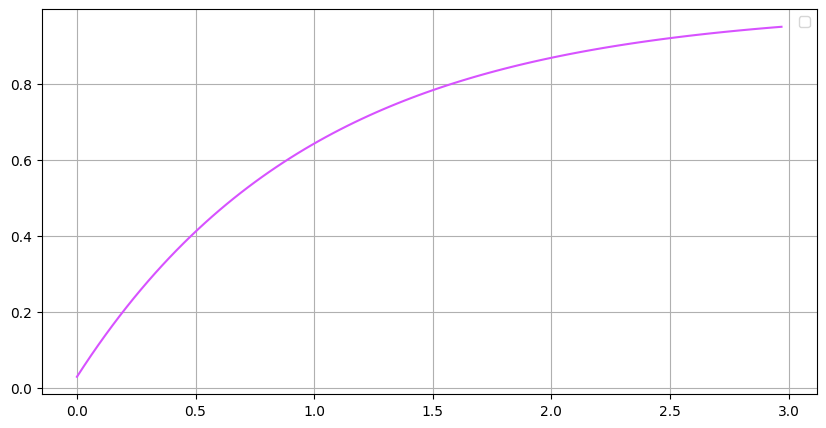

In [73]:
# data = pd.DataFrame()
# x = np.linspace(0, T, 1000)
# data['t'] = x
# y0 = [ 0, 0]

# k0 , k1 = [ 1, 1 ]
# #k0 , k1, k2 = [ 0.9, 2 , 3 ]
# sol1 = odeint(normal_DE, y0, x, args=(k0, k1, u_one))

# # # k0 , k1, k2 = [ 0.5, 1 , 1.5 ]
# # #k0 , k1, k2 = [ 0.9, 2 , 3 ]
# # sol1 = odeint(normal_DE, y0, x, args=(k0, k1, k2, u_one))

# data['obj1_one'] = sol1[:,0]
# data['obj1_one_derivative'] = sol1[:,1]

size = np.shape(approx_runge[:,0])[0]
data_sample = pd.DataFrame()
# делаем выборку с заданным периодом из всех точек что есть
#добавляем шум к данным
np.random.seed(random_state)
data_sample['t'] = approx_runge[:,0]
data_sample['obj1_one'] = approx_runge[:,1] 
# data_sample['obj1_one_derivative'] = data['obj1_one_derivative'][::period] + dispersion * np.random.normal(0,1,size)*data['obj1_one_derivative'][::period] 
# data_sample['obj1_one'] = data['obj1_one'][::period] +  np.random.normal(0,dispersion,size)
# data_sample['obj1_one_derivative'] = data['obj1_one_derivative'][::period] + np.random.normal(0,dispersion,size)
# data_sample['obj1_one'] = data['obj1_one'][::period]
# data_sample['obj1_one_derivative'] = data['obj1_one_derivative'][::period]

fig = plt.figure(figsize =(10, 5))
ax = plt.axes()
# plt.title('Восстановление весовой функции')
# ax.plot(data['t'], data['obj1_one'],c='magenta', label='$k$')
# ax.plot([0,T],[2.1,2.1])
# ax.plot([0,T],[1.9,1.9])
# ax.plot(data['t'],data['obj1_one_derivative'],'--', c='red', label='$h$')

ax.plot(data_sample['t'], data_sample['obj1_one'],c='#D752FF')
# ax.scatter(data_sample['t'], data_sample['obj1_one_derivative'],c='#D752FF', s=10)

plt.legend()
plt.grid()
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 580.86it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


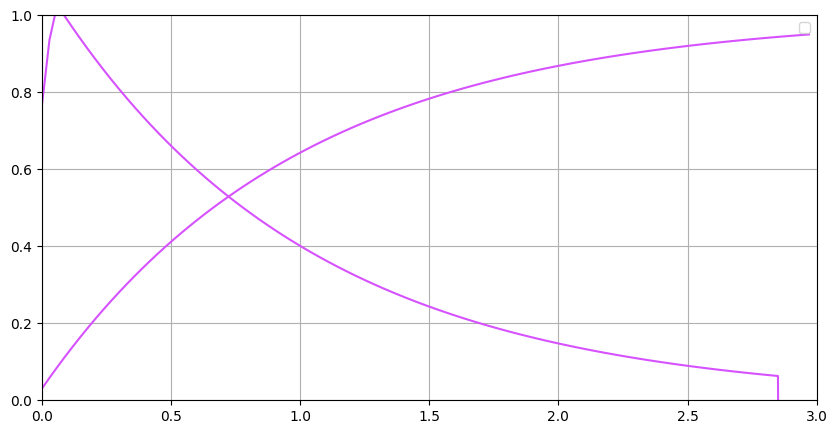

In [93]:
h = []
blur = 0.1
for i in tqdm(range(size)):
    h.append( h_estimate_opt(data_sample['t'].iloc[i], data_sample['t'], data_sample['obj1_one'], blur, nuke_Epa_der) )

data_sample['h_estimate'] = h

fig = plt.figure(figsize =(10, 5))
ax = plt.axes()
# plt.title('Восстановление весовой функции')
# ax.plot(data['t'], data['obj1_one'],c='magenta', label='$k$')
# ax.plot([0,T],[2.1,2.1])
# ax.plot([0,T],[1.9,1.9])
# ax.plot(data['t'],data['obj1_one_derivative'],'--', c='red', label='$h$')

ax.plot(data_sample['t'], data_sample['obj1_one'],c='#D752FF')
ax.plot(data_sample['t'], data_sample['h_estimate'],c='#D752FF')
# ax.scatter(data_sample['t'], data_sample['obj1_one_derivative'],c='#D752FF', s=10)

ax.set_xlim(0,3)
ax.set_ylim(0,1)
plt.legend()
plt.grid()
plt.show()


In [94]:
data_sample['t'].iloc[2] - data_sample['t'].iloc[1]

0.03

In [117]:
data_sample['h_estimate'][0] * (1 / (data_sample['h_estimate'].iloc[0] * dt))

33.333333333333336

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


i=1
i=2
    j=0    w[i]=0.0
                    w[j]=43.79001882788808
                               2 data_sample['h_estimate'].iloc[i-j]=1.027006909893166
i=3
    j=0    w[i]=0.0
                    w[j]=43.79001882788808
                               3 data_sample['h_estimate'].iloc[i-j]=0.9966542688362116
    j=1    w[i]=43.64350919723274
                    w[j]=-53.85611492360109
                               2 data_sample['h_estimate'].iloc[i-j]=1.027006909893166
i=4
    j=0    w[i]=0.0
                    w[j]=43.79001882788808
                               4 data_sample['h_estimate'].iloc[i-j]=0.9671986838849734
    j=1    w[i]=42.35364857763156
                    w[j]=-53.85611492360109
                               3 data_sample['h_estimate'].iloc[i-j]=0.9966542688362116
    j=2    w[i]=-11.32227826390907
                    w[j]=-15.290579402396522
                               2 data_sample['h_estimate'].iloc[i-j]=1.027006909893166
i=5
    j=0    w[i]=0.0
          

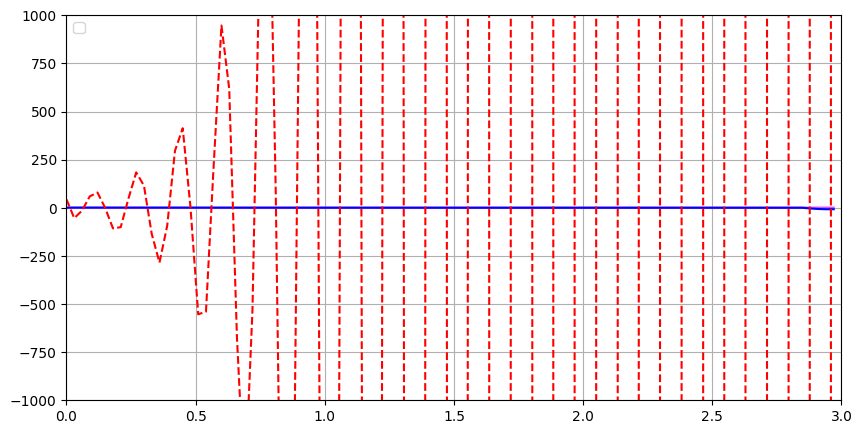

In [115]:
dt = data_sample['t'].iloc[2] - data_sample['t'].iloc[1]
size = len(data_sample['h_estimate'])
w = np.zeros(size)
w[0] = 1 / (data_sample['h_estimate'].iloc[0] * dt)
for i in range(1,size):
    print(f'{i=}')
    if i == 1:
        w[i] += (data_sample['h_estimate'][0] * w[0])
        w[i] += (data_sample['h_estimate'][1] * w[0])
    for j in range(i-1):
        print(f'    {j=}    {w[i]=}')
        print(f'                    {w[j]=}')
        print(f"                               {i-j} {data_sample['h_estimate'].iloc[i-j]=}")
        w[i] += (data_sample['h_estimate'][i-j] * w[j])
    w[i] = (1 - w[i] * dt) / (data_sample['h_estimate'].iloc[0] * dt)

data_sample['w_estimate'] = w
fig = plt.figure(figsize =(10, 5))
ax = plt.axes()
# plt.title('Восстановление весовой функции')
# ax.plot(data['t'], data['obj1_one'],c='magenta', label='$k$')
# ax.plot([0,T],[2.1,2.1])
# ax.plot([0,T],[1.9,1.9])
# ax.plot(data['t'],data['obj1_one_derivative'],'--', c='red', label='$h$')

ax.plot(data_sample['t'], data_sample['obj1_one'],c='#D752FF')
ax.plot(data_sample['t'], data_sample['h_estimate'],c='blue')
ax.plot(data_sample['t'], data_sample['w_estimate'], '--', c='red')
# ax.scatter(data_sample['t'], data_sample['obj1_one_derivative'],c='#D752FF', s=10)

ax.set_xlim(0,3)
ax.set_ylim(-1000,1000)
plt.legend()
plt.grid()
plt.show()

i=1
    j=0    w[i]=0.0
                    w[j]=1869.3666810983098
                               1 data_sample['h_estimate'].iloc[i-j]=0.012753046189615503
i=2
    j=0    w[i]=0.0
                    w[j]=1869.3666810983098
                               2 data_sample['h_estimate'].iloc[i-j]=0.01765765093162455
    j=1    w[i]=1.9824999590416492
                    w[j]=90791.70190425175
                               1 data_sample['h_estimate'].iloc[i-j]=0.012753046189615503
i=3
    j=0    w[i]=0.0
                    w[j]=1869.3666810983098
                               3 data_sample['h_estimate'].iloc[i-j]=0.0237544448252093
    j=1    w[i]=2.6670130741281937
                    w[j]=90791.70190425175
                               2 data_sample['h_estimate'].iloc[i-j]=0.01765765093162455
    j=2    w[i]=98.95339023409151
                    w[j]=-40236.78650009686
                               1 data_sample['h_estimate'].iloc[i-j]=0.012753046189615503
i=4
    j=0    w[i]=0.0
  

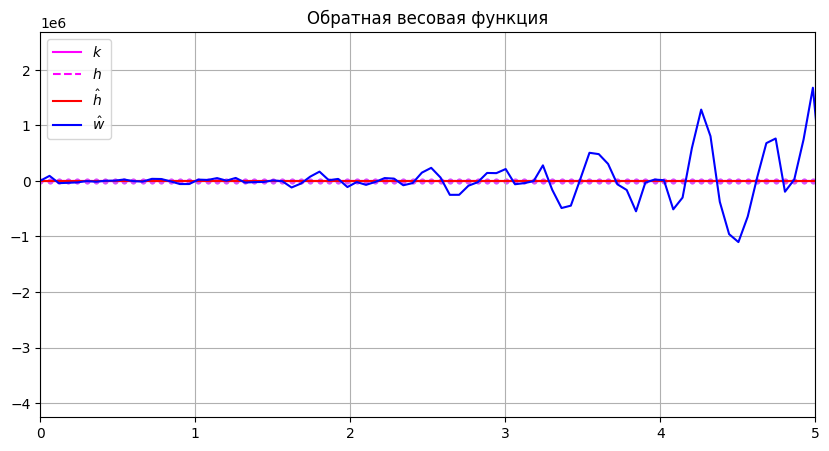

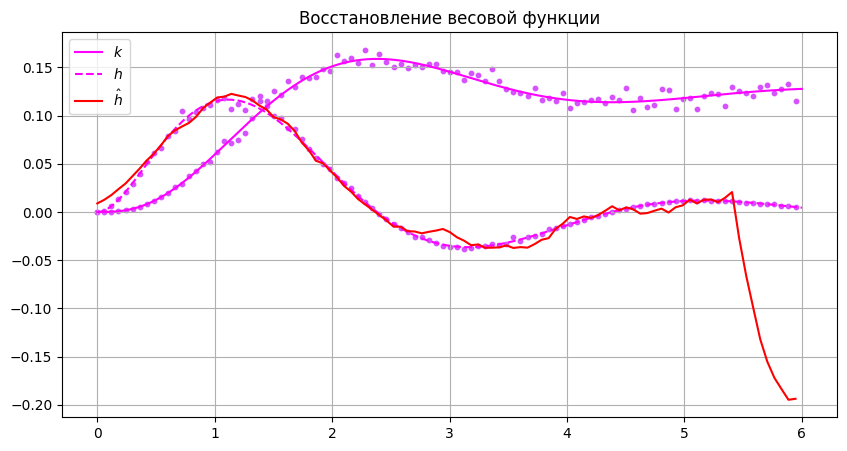

In [57]:
dt = data_sample['t'].iloc[1] - data_sample['t'].iloc[0]
size = len(data_sample['h_estimate'])
w = np.zeros(size)
w[0] = 1/(data_sample['h_estimate'].iloc[0] * dt)
for i in range(1,size):
    print(f'{i=}')
    for j in range(i):
        print(f'    {j=}    {w[i]=}')
        print(f'                    {w[j]=}')
        print(f"                               {i-j} {data_sample['h_estimate'].iloc[i-j]=}")
        w[i] += (data_sample['h_estimate'].iloc[i-j] * w[j] * dt)
    w[i] = (size*blur - w[i]) / (data_sample['h_estimate'].iloc[0] * dt)
    #w[i] = (1 - w[i] * dt) / ( dt * 0.5)

data_sample['w_estimate'] = w 
w_pic(data, data_sample)
h_pic(data,data_sample)

<Axes: >

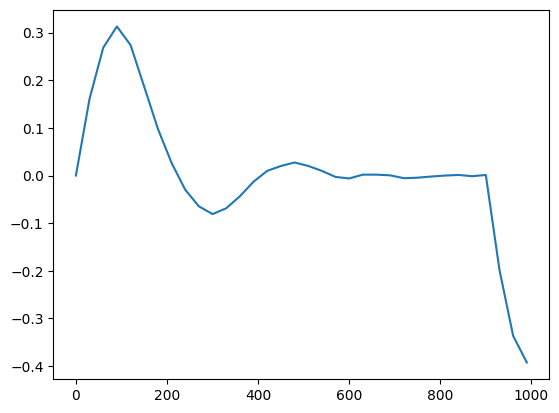

In [26]:
data_sample['AA-1'] = data_sample['h_estimate'] * data_sample['w_estimate']
data_sample['AA-1'].plot()

# fix??

i=1
i=2
    j=0    w[i]=0.0
                    w[j]=49.636099641311134
                               2 data_sample['h_estimate'].iloc[i-j]=0.10396369393051283
i=3
    j=0    w[i]=0.0
                    w[j]=49.636099641311134
                               3 data_sample['h_estimate'].iloc[i-j]=0.08904673399939268
    j=1    w[i]=4.419932561527183
                    w[j]=49.636099641311134
                               2 data_sample['h_estimate'].iloc[i-j]=0.10396369393051283
i=4
    j=0    w[i]=0.0
                    w[j]=49.636099641311134
                               4 data_sample['h_estimate'].iloc[i-j]=0.04118848593101253
    j=1    w[i]=2.0444357917464795
                    w[j]=49.636099641311134
                               3 data_sample['h_estimate'].iloc[i-j]=0.08904673399939268
    j=2    w[i]=6.464368353273663
                    w[j]=-91.38178597387048
                               2 data_sample['h_estimate'].iloc[i-j]=0.10396369393051283
i=5
    j=0    w[i]=0.0

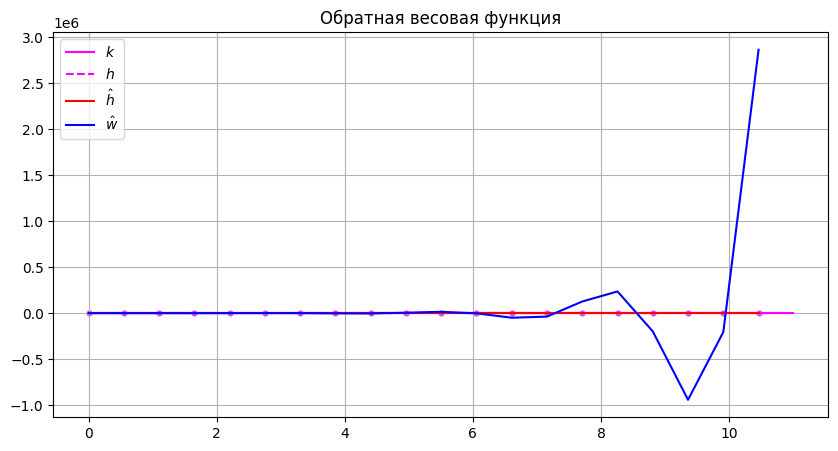

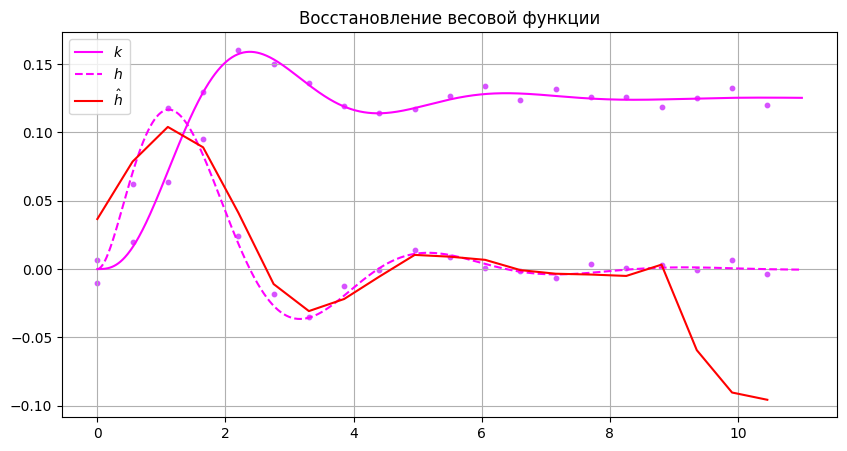

In [149]:
dt = data_sample['t'].iloc[1] - data_sample['t'].iloc[0]
size = len(data_sample['h_estimate'])
w = np.zeros(size)
w[0] = 1/(data_sample['h_estimate'].iloc[0] * dt)
for i in range(1,size):
    print(f'{i=}')
    for j in range(i-1):
        print(f'    {j=}    {w[i]=}')
        print(f'                    {w[j]=}')
        print(f"                               {i-j} {data_sample['h_estimate'].iloc[i-j]=}")
        w[i] += (data_sample['h_estimate'].iloc[i-j] * w[j])
    w[i] = (1 - w[i]*dt) * (1/(data_sample['h_estimate'].iloc[0] * dt))

data_sample['w_estimate'] = w 
w_pic(data, data_sample)
h_pic(data,data_sample)

In [116]:
data_sample

,t,obj1_one,obj1_one_derivative,h_estimate,w_estimate,k_estimate
0,0.000000,0.000000,0.000000,0.014698,0,0.004029
10,0.110110,0.000199,0.005230,0.022750,0,0.006188
20,0.220220,0.001428,0.018015,0.032584,0,0.009010
30,0.330330,0.004313,0.034811,0.043862,0,0.012622
40,0.440440,0.009143,0.052974,0.056078,0,0.017205
...,...,...,...,...,...,...
950,10.460460,0.125382,-0.000076,-0.098603,0,0.125342
960,10.570571,0.125368,-0.000175,-0.118392,0,0.125346
970,10.680681,0.125344,-0.000258,-0.131584,0,0.125346
980,10.790791,0.125312,-0.000322,-0.138180,0,0.125342


In [134]:
def x_estimate_opt(X_pred, data, par_blur, nuke_der, h_0, dt):
    c = 0
    size = len(data)

    j_list = list(data.loc[(data['t']<X_pred-dt)]['t'])
    print(f'{j_list}')
    for j in j_list:
        print(f"{j=}")
        for i in range(size):
            print(f"{float(data[data['t']==j]['w_estimate'])=}")
            c += data['obj1_one'].iloc[i] * ( nuke_der((X_pred-data['t'].iloc[i] - j)/par_blur) ) * float(data[data['t']==j]['w_estimate']) * dt
    return (1-c)/h_0

In [131]:
list(data.loc[(data['t']<0.2-dt)]['t'])[1::]

[0.011011011011011011,
 0.022022022022022022,
 0.03303303303303303,
 0.044044044044044044,
 0.055055055055055056,
 0.06606606606606606,
 0.07707707707707707,
 0.08808808808808809]

In [108]:

float(data_sample[data_sample['t']==0.11011011011011011]['w_estimate'])

0.0

In [135]:
dt = data_sample['t'].iloc[1] - data_sample['t'].iloc[0]
size = len(data_sample['h_estimate'])
data_sample['w_estimate'].iloc[0] = data_sample['h_estimate'].iloc[0]
h_0 = 1/(data_sample['h_estimate'].iloc[0] * dt)
for i in range(1,size):
    print(f'{i=}')
    #print(f"{data_sample['t'].iloc[i]=}")
    w[i] = x_estimate_opt(data_sample['t'].iloc[i], data_sample, blur, nuke_Epa_der, h_0, dt)
    print(f'{w[i]=}')


w_pic(data, data_sample)
h_pic(data,data_sample)

i=1
[]
w[i]=0.001562808845135625
i=2
[0.0]
j=0.0
float(data[data['t']==j]['w_estimate'])=0.014193145784458993
float(data[data['t']==j]['w_estimate'])=0.014193145784458993
float(data[data['t']==j]['w_estimate'])=0.014193145784458993
float(data[data['t']==j]['w_estimate'])=0.014193145784458993
float(data[data['t']==j]['w_estimate'])=0.014193145784458993
float(data[data['t']==j]['w_estimate'])=0.014193145784458993
float(data[data['t']==j]['w_estimate'])=0.014193145784458993
float(data[data['t']==j]['w_estimate'])=0.014193145784458993
float(data[data['t']==j]['w_estimate'])=0.014193145784458993
float(data[data['t']==j]['w_estimate'])=0.014193145784458993
float(data[data['t']==j]['w_estimate'])=0.014193145784458993
float(data[data['t']==j]['w_estimate'])=0.014193145784458993
float(data[data['t']==j]['w_estimate'])=0.014193145784458993
float(data[data['t']==j]['w_estimate'])=0.014193145784458993
float(data[data['t']==j]['w_estimate'])=0.014193145784458993
float(data[data['t']==j]['w_estimate

KeyboardInterrupt: 

In [54]:
data_sample

,t,obj1_one,obj1_one_derivative,h_estimate,w_estimate
0,0.000000,0.000000,0.000000,0.006535,0
5,0.055055,0.000026,0.001408,0.009948,0
10,0.110110,0.000199,0.005230,0.014280,0
15,0.165165,0.000637,0.010923,0.019548,0
20,0.220220,0.001428,0.018015,0.025723,0
...,...,...,...,...,...
975,10.735736,0.125329,-0.000292,-0.195006,0
980,10.790791,0.125312,-0.000322,-0.221564,0
985,10.845846,0.125294,-0.000348,-0.239259,0
990,10.900901,0.125274,-0.000369,-0.248093,0


In [49]:
data_sample['t'].iloc[1]

0.055055055055055056

In [ ]:
data_sample[data_sample['t']==0]['w_estimate']

0.0

In [44]:
list(data_sample.loc[data_sample['t']<1]['t'])

[0.0,
 0.055055055055055056,
 0.11011011011011011,
 0.16516516516516516,
 0.22022022022022023,
 0.2752752752752753,
 0.3303303303303303,
 0.38538538538538536,
 0.44044044044044045,
 0.4954954954954955,
 0.5505505505505506,
 0.6056056056056056,
 0.6606606606606606,
 0.7157157157157157,
 0.7707707707707707,
 0.8258258258258259,
 0.8808808808808809,
 0.9359359359359359,
 0.990990990990991]